In [1]:
import math
import PIL.Image as Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import IPython.display as disp
from torch.utils.data import DataLoader
from torch import Tensor
from datasets import load_dataset
from torchvision import transforms
from compressai.models import CompressionModel
from compressai.entropy_models import EntropyBottleneck
from compressai.ops.parametrizers import NonNegativeParametrizer

In [2]:
def analysis_1d(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.Conv1d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        padding=kernel_size // 2,
    )

In [3]:
def synthesis_1d(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.ConvTranspose1d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        output_padding=stride - 1,
        padding=kernel_size // 2,
    )

In [4]:
class GDN_1d(nn.Module):

    def __init__(
        self,
        in_channels: int,
        inverse: bool = False,
        beta_min: float = 1e-6,
        gamma_init: float = 0.1,
    ):
        super().__init__()

        beta_min = float(beta_min)
        gamma_init = float(gamma_init)
        self.inverse = bool(inverse)

        self.beta_reparam = NonNegativeParametrizer(minimum=beta_min)
        beta = torch.ones(in_channels)
        beta = self.beta_reparam.init(beta)
        self.beta = nn.Parameter(beta)

        self.gamma_reparam = NonNegativeParametrizer()
        gamma = gamma_init * torch.eye(in_channels)
        gamma = self.gamma_reparam.init(gamma)
        self.gamma = nn.Parameter(gamma)

    def forward(self, x: Tensor) -> Tensor:
        _, C, _ = x.size()

        beta = self.beta_reparam(self.beta)
        gamma = self.gamma_reparam(self.gamma)
        gamma = gamma.reshape(C, C, 1)
        norm = F.conv1d(x**2, gamma, beta)

        if self.inverse:
            norm = torch.sqrt(norm)
        else:
            norm = torch.rsqrt(norm)

        out = x * norm

        return out

In [5]:
class RateDistortionAutoEncoder(CompressionModel):
    def __init__(self, N=128):
        super().__init__()
        self.entropy_bottleneck = EntropyBottleneck(N)
        self.encode = nn.Sequential(
            analysis_1d(12, N),
            GDN_1d(N),
            analysis_1d(N, N),
            GDN_1d(N),
            analysis_1d(N, N),
        )

        self.decode = nn.Sequential(
            synthesis_1d(N, N),
            GDN_1d(N, inverse=True),
            synthesis_1d(N, N),
            GDN_1d(N, inverse=True),
            synthesis_1d(N, 12),
        )

    def forward(self, x):
        y = self.encode(x)
        y_hat, y_likelihoods = self.entropy_bottleneck(y)
        x_hat = self.decode(y_hat)
        return x_hat, y_likelihoods

In [6]:
def live_plot(rate, distortion):
    disp.clear_output(wait=True)
    plt.figure(figsize=(10, 6))
    
    plt.subplot(2, 1, 1)
    plt.plot(rate)
    plt.title('Rate')
    plt.xlabel('Iteration')
    plt.ylabel('Bits per Sample')
    
    plt.subplot(2, 1, 2)
    plt.plot(np.log(distortion))
    plt.title('Distortion')
    plt.xlabel('Iteration')
    plt.ylabel('log(Mean Square Error)')
    
    plt.tight_layout()
    plt.show()

In [7]:
dataset = load_dataset("danjacobellis/MYRiAD_V2",split='train[:-50]').with_format("torch")

Resolving data files:   0%|          | 0/34 [00:00<?, ?it/s]

In [8]:
net = RateDistortionAutoEncoder().to("cuda")
parameters = set(p for n, p in net.named_parameters() if not n.endswith(".quantiles"))
aux_parameters = set(p for n, p in net.named_parameters() if n.endswith(".quantiles"))
optimizer = optim.AdamW(parameters, lr=1e-4)
aux_optimizer = optim.AdamW(aux_parameters, lr=1e-3)
λ = 1e-5

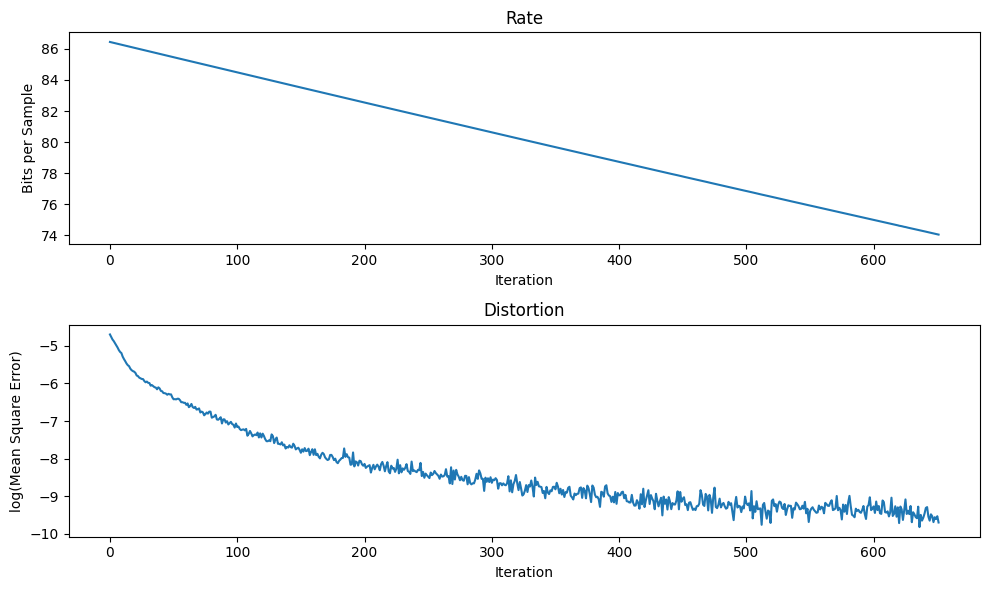

In [ ]:
rate = np.array([])
distortion = np.array([])
for i_epoch in range(5000):
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    for i,batch in enumerate(dataloader):
        optimizer.zero_grad()
        aux_optimizer.zero_grad()
    
        x = batch['acoustic'].to("cuda")
        x = x.to(torch.float)
        
        x_hat, y_likelihoods = net(x)
        
        # bitrate of the quantized latent
        N, _, L = x.size()
        num_samples = N * L
        bps_loss = torch.log(y_likelihoods).sum() / (-math.log(2) * num_samples)
        rate = np.append(rate,bps_loss.detach().cpu().numpy())
        
        # mean square error
        mse_loss = F.mse_loss(x, x_hat)
        distortion = np.append(distortion,mse_loss.detach().cpu().numpy())
        
        # final loss term
        loss = mse_loss + λ * bps_loss
        
        loss.backward()
        optimizer.step()
        
        aux_loss = net.aux_loss()
        aux_loss.backward()
        aux_optimizer.step()

    torch.save({
            'epoch': i,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'aux_optimizer_state_dict': aux_optimizer.state_dict(),
            'loss': loss,
        }, f"rdae_MYRiAD_V2_checkpoint.pth")
    live_plot(rate,distortion)
    np.save('rate',rate)
    np.save('distortion',distortion)